# Test of the new Reflected Bkg with Gammapy (run pipeline)

In this tutorial we will learn how to perform a 1d spectral analysis.

We will use a "pipeline" or "workflow" class to run a standard analysis. If you're interested in implementation detail of the analysis in order to create a custom analysis class, you should read ([spectrum_analysis.ipynb](spectrum_analysis.ipynb)) that executes the analysis using lower-level classes and methods in Gammapy. 

In this tutorial we will use the folling Gammapy classes:

- [gammapy.data.DataStore](https://docs.gammapy.org/dev/api/gammapy.data.DataStore.html) to load the data to 
- [gammapy.scripts.SpectrumAnalysisIACT](https://docs.gammapy.org/dev/api/gammapy.scripts.SpectrumAnalysisIACT.html) to run the analysis

We use 4 Crab observations from H.E.S.S. for testing.

## Setup

As usual, we'll start with some setup for the notebook, and import the functionality we need.

In [50]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, CircleAnnulusSkyRegion, EllipseSkyRegion, EllipseAnnulusSkyRegion, RectangleSkyRegion, RectangleAnnulusSkyRegion, PolygonSkyRegion

from gammapy.data import DataStore
from gammapy.catalog import SourceCatalogGammaCat
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.stats import significance_on_off

## Select data

First, we select and load some H.E.S.S. data (simulated events for now). In real life you would do something fancy here, or just use the list of observations someone send you (and hope they have done something fancy before). We'll just use the standard gammapy 4 crab runs.

In [13]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_ids = data_store.obs_table["OBS_ID"][mask].data
observations = data_store.get_observations(obs_ids)
print(obs_ids)

[23523 23526 23559 23592]


## Configure the analysis

Now we'll define the input for the spectrum analysis. It will be done the python way, i.e. by creating a config dict containing python objects. We plan to add also the convenience to configure the analysis using a plain text config file.

In [14]:
crab_pos = SkyCoord.from_name("crab")
print(crab_pos)
on_region = CircleSkyRegion(crab_pos, 0.15 * u.deg)

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>


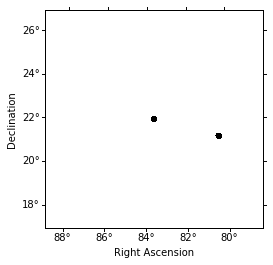

In [15]:
exclusion_mask = Map.create(skydir=crab_pos, width=(10, 10), binsz=0.02)

gammacat = SourceCatalogGammaCat("$GAMMAPY_DATA/catalogs/gammacat/gammacat.fits.gz")

regions = []
for source in gammacat:
    if not exclusion_mask.geom.contains(source.position):
        continue
    region = CircleSkyRegion(source.position, 0.15 * u.deg)
    regions.append(region)

exclusion_mask.data = exclusion_mask.geom.region_mask(regions, inside=False)
exclusion_mask.plot();

In [16]:
config = dict(
    outdir=".",
    background=dict(
        on_region=on_region,
        exclusion_mask=exclusion_mask,
        min_distance=0.1 * u.rad,
    )
)

## Test different region type

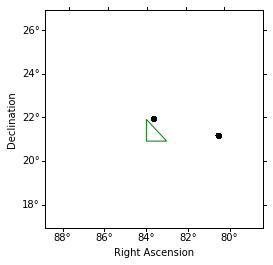

In [29]:
polygon_sky = PolygonSkyRegion(vertices=SkyCoord([83, 84, 84], [21, 21, 22], unit='deg', frame='icrs'))
exclusion_mask.plot();
polygon_pix = polygon_sky.to_pixel(exclusion_mask.geom.wcs)
polygon_pix.plot();

## Configuration of the Reflected Bg Makers


In [6]:
background_estimator = ReflectedRegionsBackgroundEstimator(
            observations=observations, **config["background"]
        )

## Results

Let's look at the results, and also compare with a previously published Crab nebula spectrum for reference.

In [7]:
background_estimator.run()

/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


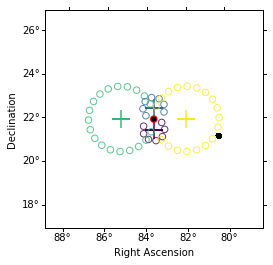

In [32]:
background_estimator.plot();

In [54]:
on_s = 0
off_s = 0
a_on_s = 0
a_off_s = 0
for obs_result in background_estimator.result:
    on_s += len(obs_result.on_events.table)
    off_s += len(obs_result.off_events.table)
    a_on_s += obs_result.a_on
    a_off_s += obs_result.a_off
    print(obs_result)
    print("\n")

alpha = a_on_s/a_off_s
excess = on_s - off_s*alpha
sigma = significance_on_off(on_s, off_s, alpha)
print("\n Total ON : {0} | Total OFF : {1} | Alpha : {2:.4f}".format(on_s, off_s, alpha))
print(" Total Excess : {0:.2f} | Sigma = {1:.2f}".format(excess, sigma))

BackgroundEstimate
 Method: Reflected Regions
 on region
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>
radius: 0.15 deg
 EventList info:
- Number of events: 255
- Median energy: 0.97 TeV
- OBS_ID = 23523
 off region
 [<CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.2431752, 21.85885133)>, radius=0.14999999999253538 deg)>, <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.09646833, 21.53941178)>, radius=0.14999999993203264 deg)>, <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.20884846, 21.2082476)>, radius=0.14999999988431817 deg)>, <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.52488403, 21.02470889)>, radius=0.14999999998608982 deg)>, <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.89278087, 21.07671017)>, radius=0.14999999994166663 deg)>, <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (84.13649036, 21.3393719)>, radius=0.14999999988533153 deg)>, <CircleSkyRegion(<Sky